In [55]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import sys
from pathlib import Path
import xarray as xr
import cfgrib
import cartopy.crs as ccrs  # Projeções de mapas.
import cartopy.feature as cfeature  # Elementos geográficos.
from matplotlib.tri import Triangulation

#Import local libraries
import aux

In [56]:
year='2018'
month='12'
month_abbr = datetime.datetime.strptime(month, "%m").strftime("%b")

base_dir='/pesq/dados/monan/users/madeleine.gacita/global_data/'
exps_data={
    "CTRL": {
        "dir": f"/pesq/dados/monan/users/lianet.hernandez/global_clm_2018-2019/CTRL/derived_data/"},
    "land_mult_24": {
        "dir": f"/pesq/dados/monan/users/lianet.hernandez/global_clm_2018-2019/land_mult_24/derived_data/"},
}
extents={"SA":{
            "extent":[-90, -30, -40, 10],
            "label":"South America"},
        "Global":{
            "extent":[-180, 180, -90, 90],
            "label":"Global"},
        }


In [57]:
var_dict={
    "ISR": {
        "era5_name" : "ssrd",
        "era5_longname" :"surface_solar_radiation_downwards",
        "ceres_name" : "init_all_sfc_sw_dn", 
        "monan_name" : "swdnb",
        "unit" : "W m^{-2}",
        "label" : "Surface shortwave radiation downwards",
        "convert_to_flux": "yes",
        "vmin" : 0,
        "vmax" : 1300
    },
    "ISRC": {
        "era5_name" : "ssrdc",
        "era5_longname" :"surface_solar_radiation_downward_clear_sky",
        "ceres_name" : "init_clr_sfc_sw_dn", 
        "monan_name" : "swdnbc",
        "unit" : "W m^{-2}",
        "label" : "Surface shortwave radiation downwards (clear sky)",
        "convert_to_flux": "yes",
        "vmin" : 0,
        "vmax" : 1300
    },
    "OLR": {
        "era5_name": "ttr",
        "era5_longname" :"top_net_thermal_radiation",
        "ceres_name" : "init_all_toa_lw_up", 
        "monan_name" : "lwupt",
        "unit" : "W m^{-2}",
        "label" : "TOA Outgoing longwave radiation",
        "convert_to_flux": "yes",
        "vmin" : -400,
        "vmax" : 0
    },
    "OLRC": {
        "era5_name" : "ttrc",
        "era5_longname" : "top_net_thermal_radiation_clear_sky",
        "ceres_name" : "init_clr_toa_lw_up", 
        "monan_name" : "lwuptc",
        "unit" : "W m^{-2}",
        "label" : "TOA Outgoing longwave radiation (clear sky)",
        "convert_to_flux": "yes",
        "vmin" : -400,
        "vmax" : 0
    },
    "TISR": {
        "era5_name" : "tisr",
        "era5_longname" : "toa_incident_solar_radiation",
        "ceres_name" : "toa_sw_insol", 
        "monan_name" : "swdnt",
        "unit" : "W m^{-2}",
        "label" : "TOA incident short-wave (solar) radiation",
        "convert_to_flux": "yes",
        "vmin" : 0,
        "vmax" : 1300
    },
    "CAPE": {
        "era5_name" : "cape",
        "era5_longname" : "convective_available_potential_energy",
        "ceres_name" : "cape", 
        "monan_name" : "cape",
        "unit" : "J kg^{-1}",
        "label" : "Convective available potential energy",
        "convert_to_flux": "no",
        "vmin" : 0,
        "vmax" : 2000
    },
    "CIN": {
        "era5_name" : "cin",
        "era5_longname" : "convective_inhibition",
        "ceres_name" : "cin", 
        "monan_name" : "cin",
        "unit" : "J kg^{-1}",
        "label" : "Convective inhibition",
        "convert_to_flux": "no",
        "vmin" : 0,
        "vmax" : 300
    }
}

surf_flux_dict={
    "HF": {
        "era5_name" : "sshf",
        "era5_longname" : "surface_sensible_heat_flux",
        "monan_name" : "hfx", 
        "unit" : "W/m**2",
        "label" : "Sensible heat flux"
    },
    "LF": {
        "era5_name": "sslf",
        "era5_longname":"surface_latent_heat_flux",
        "monan_name": "lf", 
        "unit": "W m^{-2}",
        "label": "Latent heat flux"
    }
}

profile_vars_dict={
    "ISR": {
        "monan_name" : "ssrd",
        "ceres_name" : "adj_all_sw_dn",
        "unit" : "W m^{-2}",
        "label" : "Incoming shortwave radiation"
    },
    "OSR": {
        "monan_name" : "ssrd",
        "ceres_name" : "adj_all_sw_up", 
        "unit" : "W m^{-2}",
        "label" : "Outgoing shortwave radiation"
    },
    "ILR": {
        "monan_name" : "ttrc",
        "ceres_name" : "adj_all_lw_dn", 
        "unit" : "W m^{-2}",
        "label" : "Incoming longwave radiation"
    },
    "OLR": {
        "monan_name" : "ttr",
        "ceres_name" : "adj_all_lw_up", 
        "unit" : "W m^{-2}",
        "label" : "Outgoing longwave radiation"
    }    
}

In [58]:
def apply_lon_lat_conventions(ds):
    # Renames
    if "lon" in ds.dims:
        ds = ds.rename({"lon": "longitude"})
    if "lat" in ds.dims:
        ds = ds.rename({"lat": "latitude"})
 
    # Flip latitudes (ensure they are monotonic increasing)
    if "latitude" in ds.dims:
        lats = ds["latitude"]
        if len(lats) > 1 and lats[0] > lats[-1]:
            ds = ds.reindex(latitude=ds.latitude[::-1])
 
    # Convert longitude to [-180, 180[
    if "longitude" in ds.dims and ds["longitude"].max() > 180:
        lons = ds["longitude"]
        lons_attrs = lons.attrs
        new_lons = np.concatenate([lons[lons >= 180], lons[lons < 180]])
        ds = ds.reindex(longitude=new_lons)
        ds = ds.assign_coords(longitude=(((ds["longitude"] + 180) % 360) - 180))
        ds["longitude"].attrs = lons_attrs
    return ds

# Opening CERES SYN_1deg Ed A

In [59]:
syn_file_arg = base_dir+"CER_SYN1deg-MHour/Terra-Aqua-MODIS_Edition4A/CER_SYN1deg-MHour_Terra-Aqua-MODIS_Edition4A_407406."+year+month+".hdf"
path = Path(syn_file_arg)
print(syn_file_arg)

if not path.exists():
    print(f"File does not exist: {path!s}")
else:
    from pyhdf.SD import SD, SDC
    sd = SD(str(path), SDC.READ)
    print("pyhdf.SD opened file — datasets:")
    ceres_names = list(sd.datasets().keys())

/pesq/dados/monan/users/madeleine.gacita/global_data/CER_SYN1deg-MHour/Terra-Aqua-MODIS_Edition4A/CER_SYN1deg-MHour_Terra-Aqua-MODIS_Edition4A_407406.201812.hdf
pyhdf.SD opened file — datasets:


# Selecting and plotting var

### Plots general settings

In [60]:
var="OLR"
if var_dict[var]["convert_to_flux"]=="yes":
    era_var_name = f'{var_dict[var]["era5_name"]}_flux'
else:
    era_var_name = var_dict[var]["era5_name"]
fig_path="/pesq/dados/monan/users/madeleine.gacita/figuras_rodada/"

UTC_hour_plot=15
target_lon = -60.0

## Opening MONAN data and extracting {var}

In [61]:
for exp in exps_data.keys():
    exp_name=exp
    print(f"Processing experiment: {exp_name}" )
    monan_dir=exps_data[exp]["dir"]

    monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{var_dict[var]["monan_name"]}_MHourly.nc'

    monan_path = Path(monan_file)
    if os.path.exists(monan_path):
        exps_data[exp]["ds_monan"] = xr.open_dataset(monan_path, engine="h5netcdf")
        # Adjusting sign of OLR / OLRC as negative outgoing
        if var=="OLR" or var=="OLRC":
            exps_data[exp]["ds_monan"][var_dict[var]['monan_name']] = 0 - exps_data[exp]["ds_monan"][var_dict[var]['monan_name']]
        print(exps_data[exp]["ds_monan"])
        exps_data[exp]["ds_sel_time"] = exps_data[exp]["ds_monan"][var_dict[var]['monan_name']].where(exps_data[exp]["ds_monan"]['hour'] == UTC_hour_plot, drop=True).mean(dim='hour')
        exps_data[exp]["ds_mean"] = exps_data[exp]["ds_monan"][var_dict[var]['monan_name']].mean(dim='hour')
    else:
        print(f"File does not exist: {monan_path!s}")

Processing experiment: CTRL


/tmp/ipykernel_623935/2186212849.py:10: FutureWarning: In a future version, xarray will not decode the variable 'local_hour' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  exps_data[exp]["ds_monan"] = xr.open_dataset(monan_path, engine="h5netcdf")


<xarray.Dataset> Size: 199MB
Dimensions:     (hour: 24, nCells: 655362)
Coordinates:
  * hour        (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
    lat         (nCells) float64 5MB ...
    lon         (nCells) float64 5MB ...
Dimensions without coordinates: nCells
Data variables:
    local_hour  (hour, nCells) timedelta64[ns] 126MB ...
    lwupt       (hour, nCells) float32 63MB -277.1 -265.9 ... -247.4 -246.9
Processing experiment: land_mult_24


/tmp/ipykernel_623935/2186212849.py:10: FutureWarning: In a future version, xarray will not decode the variable 'local_hour' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  exps_data[exp]["ds_monan"] = xr.open_dataset(monan_path, engine="h5netcdf")


<xarray.Dataset> Size: 199MB
Dimensions:     (hour: 24, nCells: 655362)
Coordinates:
  * hour        (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
    lat         (nCells) float64 5MB ...
    lon         (nCells) float64 5MB ...
Dimensions without coordinates: nCells
Data variables:
    lwupt       (hour, nCells) float32 63MB -272.3 -261.1 ... -240.6 -239.9
    local_hour  (hour, nCells) timedelta64[ns] 126MB ...


### Plotting for {UTC_hour_plot}

Plotting for experiment: CTRL


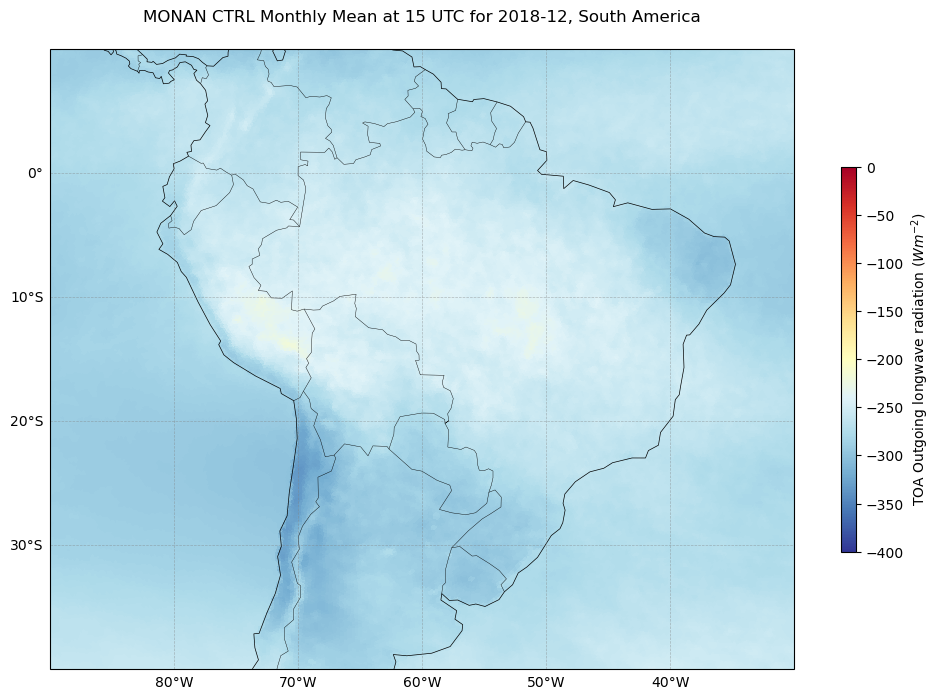

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_OLR_2018_12_15_CTRL_SA.png


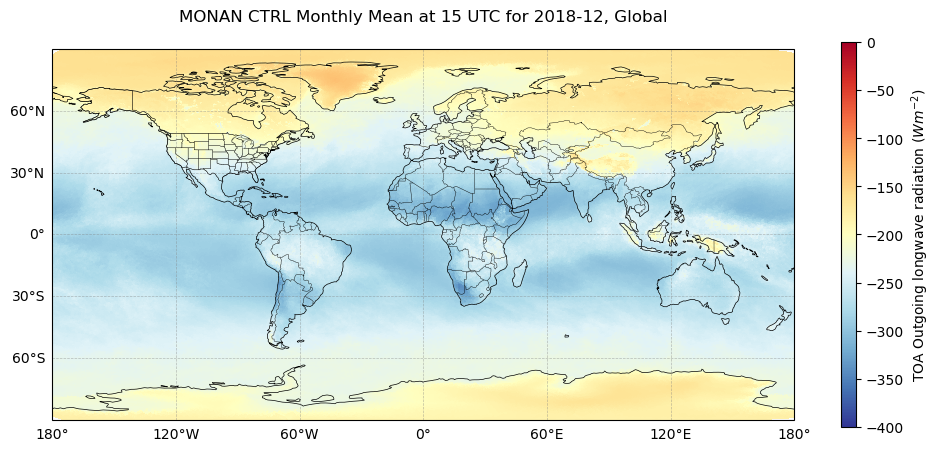

In [ ]:
#plot for exp_name
for exp in ["CTRL", "land_mult_24"]:
    exp_name=exp
    print(f"Plotting for experiment: {exp_name}" )
    monan_dir=exps_data[exp]["dir"]

    monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{var_dict[var]["monan_name"]}_MHourly.nc'

    monan_path = Path(monan_file)
    if os.path.exists(monan_path):    
        monan_lons=exps_data[exp]["ds_monan"]['lon']
        monan_lats =exps_data[exp]["ds_monan"]['lat']
        # Create triangulation
        tri = Triangulation(monan_lons, monan_lats)            
        # Plot using coordinates; try to orient lat/lon if dimensions suggest it
        for myext in extents.keys():
            extent_label=extents[myext]["label"]
            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

            # Plot
            tpc = ax.tripcolor(
                tri, exps_data[exp]["ds_sel_time"], 
                cmap="RdYlBu_r", 
                shading="flat",
                vmin=var_dict[var]['vmin'],
                vmax=var_dict[var]['vmax']
                )
            ax.set_extent(extents[myext]["extent"], crs=ccrs.PlateCarree())
            plt.colorbar(tpc, label= f"{var_dict[var]['label']} (${var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

            # Add geographic features
            ax.coastlines(linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            ax.add_feature(cfeature.STATES, linewidth=0.2)

            # Add gridlines with labels
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size': 10}
            gl.ylabel_style = {'size': 10}

            ax.set_title(f"MONAN {exp_name} Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}, {extent_label}", fontsize=12, pad=20)

            plt.tight_layout()
            out_png = f"{fig_path}/MONAN_{var}_{year}_{month}_{UTC_hour_plot}_{exp_name}_{myext}.png"
            plt.savefig(out_png, dpi=150, bbox_inches='tight')
            plt.show()

            print(f"Saved plot to: {out_png}")
            plt.close()

    else:
        print(f"File does not exist: {monan_path!s}")

### Plotting mean (all hours)

Plotting 24-hour accumulation for experiment: CTRL


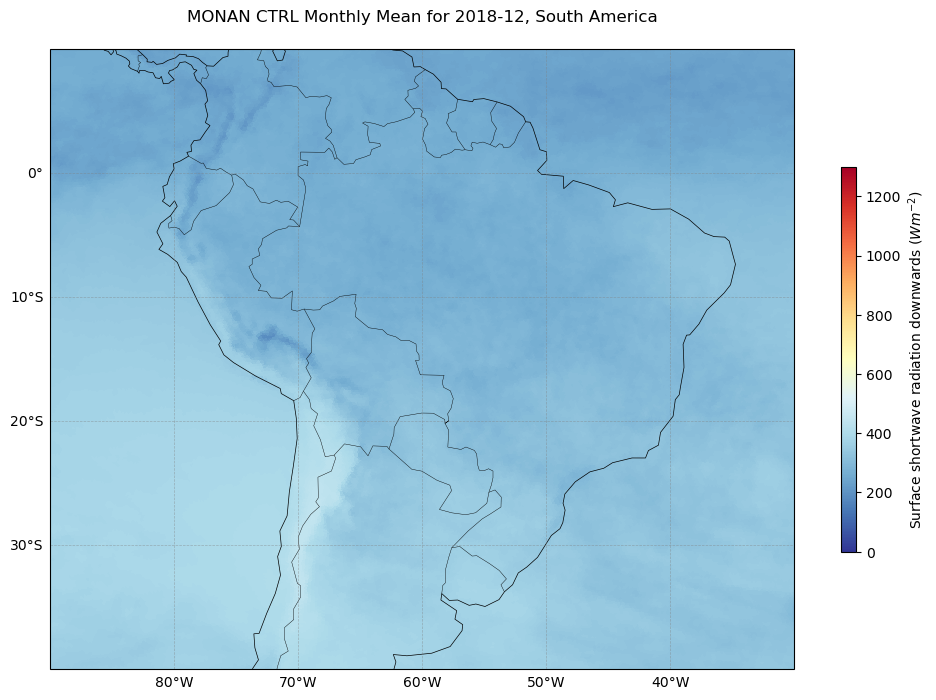

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_ISR_2018_12_mean_CTRL_SA.png


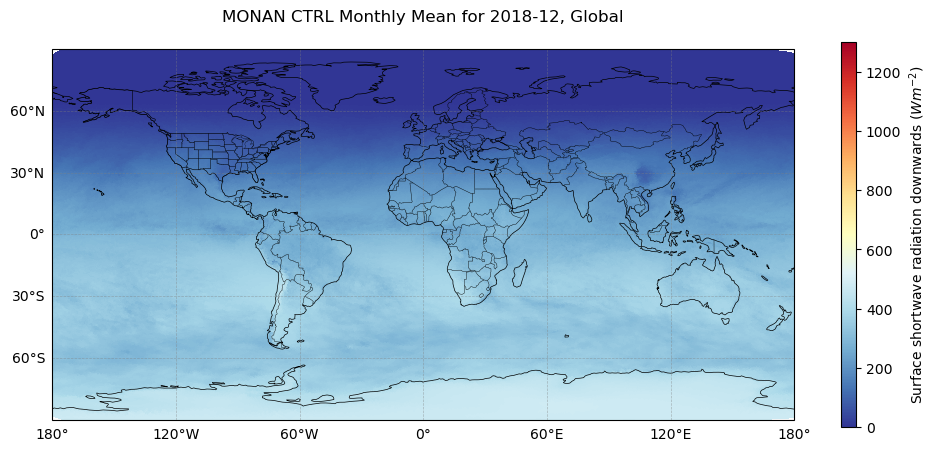

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_ISR_2018_12_mean_CTRL_Global.png
Plotting 24-hour accumulation for experiment: land_mult_24


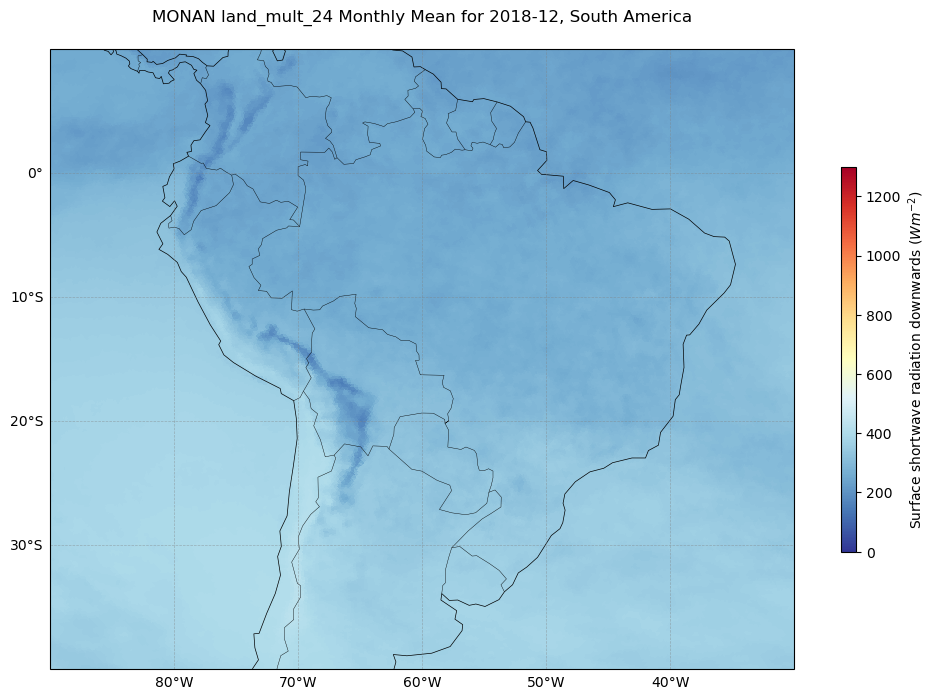

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_ISR_2018_12_mean_land_mult_24_SA.png


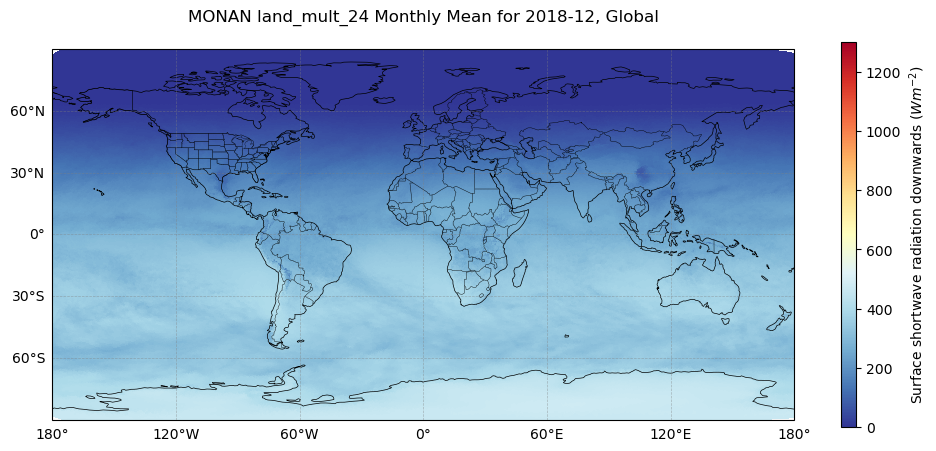

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_ISR_2018_12_mean_land_mult_24_Global.png


In [ ]:
for exp in ["CTRL", "land_mult_24"]:
    exp_name=exp
    print(f"Plotting 24-hour accumulation for experiment: {exp_name}" )
    monan_dir=exps_data[exp]["dir"]

    monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{var_dict[var]["monan_name"]}_MHourly.nc'

    monan_path = Path(monan_file)
    if os.path.exists(monan_path):    
        monan_lons=exps_data[exp]["ds_monan"]['lon']
        monan_lats =exps_data[exp]["ds_monan"]['lat']
        # Create triangulation
        tri = Triangulation(monan_lons, monan_lats)      
        # Plot using coordinates; try to orient lat/lon if dimensions suggest it
        for myext in extents.keys():
            extent_label=extents[myext]["label"]
            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

            # Plot
            tpc = ax.tripcolor(
                tri, exps_data[exp]["ds_mean"], 
                cmap="RdYlBu_r", 
                shading="flat",
                vmin=var_dict[var]['vmin'],
                vmax=var_dict[var]['vmax']
                )
            ax.set_extent(extents[myext]["extent"], crs=ccrs.PlateCarree())
            plt.colorbar(tpc, label= f"{var_dict[var]['label']} (${var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

            # Add geographic features
            ax.coastlines(linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            ax.add_feature(cfeature.STATES, linewidth=0.2)

            # Add gridlines with labels
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size': 10}
            gl.ylabel_style = {'size': 10}

            ax.set_title(f"MONAN {exp_name} Monthly Mean for {year}-{month}, {extent_label}", fontsize=12, pad=20)

            plt.tight_layout()
            out_png = f"{fig_path}/MONAN_{var}_{year}_{month}_mean_{exp_name}_{myext}.png"
            plt.savefig(out_png, dpi=150, bbox_inches='tight')
            plt.show()

            print(f"Saved plot to: {out_png}")
            plt.close()

    else:
        print(f"File does not exist: {monan_path!s}")

## Extracting CERES {var} data from opened file

In [ ]:
print(var_dict[var]['monan_name'])

swdnb


In [ ]:
ceres_var_name = var_dict[var]['ceres_name']
print(f"Trying reading dataset: {ceres_var_name}")
if ceres_var_name in ceres_names:
    sds = sd.select(ceres_var_name)
    CER_data = sds.get()              
    print(f"{sds.info()}") # shows name, rank, dims, type
    dims = sds.info()[2]

    #     # Apply scale/offset if present in attributes
    attrs = sds.attributes()

    scale = attrs.get('scale_factor') or attrs.get('scale') or attrs.get('SCALE')
    offset = attrs.get('add_offset') or attrs.get('offset') or attrs.get('OFFSET')
    fillvalue  = attrs.get('fill_value') or attrs.get('_FillValue')
    datamin,datamax = attrs.get('valid_range')
    unit = attrs.get('units')

    if scale is not None:
        CER_data = CER_data * float(scale)
    if offset is not None:
        CER_data = CER_data + float(offset)
    CER_data_masked = np.where(CER_data < datamax, CER_data, np.nan) 

    if unit == "cm":
        # converting to kg/m2
        CER_data_masked = CER_data_masked * 10
    elif unit == "g m-2":
        # converting to kg/m2
        CER_data_masked = CER_data_masked / 1000

    # Find longitude and latitude coordinates for georeferenced plotting
    lon_coords = None
    lat_coords = None
    lon_names = [n for n in ceres_names if 'lon' in n.lower() or 'longitude' in n.lower()]
    for lname in lon_names:
        try:
            lds = sd.select(lname)
            try:
                lvals = lds.get()
            except Exception:
                lvals = lds[:]
            lon_coords = np.array(lvals)
            try:
                lds.end()
            except Exception:
                pass
            break
        except Exception:
            continue
    lat_names = [n for n in ceres_names if 'lat' in n.lower() or 'latitude' in n.lower()]
    for lname in lat_names:
        try:
            lds = sd.select(lname)
            try:
                lvals = lds.get()
            except Exception:
                lvals = lds[:]
            lat_coords = np.array(lvals)
            try:
                lds.end()
            except Exception:
                pass
            break
        except Exception:
            continue

    #     Getting GMT time
    hour_data = sd.select('gmt_hr_index').get()

    if (len(dims)>3 and 5 in dims):      
    #     We have a cloud layer dim
        cld_index = sd.select('cloud_layer').get()


    # # Creating Xarray
    if (len(dims)>3 and 5 in dims):      
    #     Have a cloud layer dim
        if "CER_data_xa" in locals() and isinstance(locals()["CER_data_xa"], xr.Dataset):
            print(f'Adding {ceres_var_name} to dataArray')
            CER_data_xa[ceres_var_name] = (("cloud_layer","gmt_hr_index", "lat", "lon"), CER_data_masked)
        else:
            print('Creating DataSet')
            CER_data_xa = xr.Dataset(
                {
                    ceres_var_name: (("cloud_layer", "gmt_hr_index", "lat", "lon"), CER_data_masked)
                },
                coords={
                    "cloud_layer": cld_index,
                    "gmt_hr_index": hour_data,
                    "lat": lat_coords,
                    "lon": lon_coords,
                }
            )
    else:
    #     Have a cloud layer dim
        if "CER_data_xa" in locals() and isinstance(locals()["CER_data_xa"], xr.Dataset):
            print(f'Adding {ceres_var_name} to dataArray')
            CER_data_xa[ceres_var_name] = (("gmt_hr_index", "lat", "lon"), CER_data_masked)
        else:
            print('Creating DataSet')
            CER_data_xa = xr.Dataset(
                {
                    ceres_var_name: (( "gmt_hr_index", "lat", "lon"), CER_data_masked)
                },
                coords={
                    "gmt_hr_index": hour_data,
                    "lat": lat_coords,
                    "lon": lon_coords,
                }
            )

    # Adjusting sign of OLR / OLRC as negative outgoing
    if var=="OLR" or var=="OLRC":
        CER_data_xa[ceres_var_name] = 0 - CER_data_xa[ceres_var_name]

    utc_hours = CER_data_xa['gmt_hr_index'].values   # shape (24,)
    lon = CER_data_xa['lon'].values                  # shape (360,)

    # Longitude offset in hours
    lon_offset_hours = lon / 15.0

    # Broadcast to (gmt_hr_index, lon)
    local_hour = (utc_hours[:, None] + lon_offset_hours[None, :]) % 24
    local_hour = local_hour.astype(int)

    # Assign as coordinate
    CER_data_xa = CER_data_xa.assign_coords(local_hour=(("gmt_hr_index", "lon"), local_hour))
else:
    print(f"Variable {ceres_var_name} not found in CERES SYN1deg-MHour file.")

Trying reading dataset: init_all_sfc_sw_dn
('init_all_sfc_sw_dn', 3, [24, 180, 360], 5, 5)
Creating DataSet


## Plotting CERES {var} data at {UTC_hour_plot}

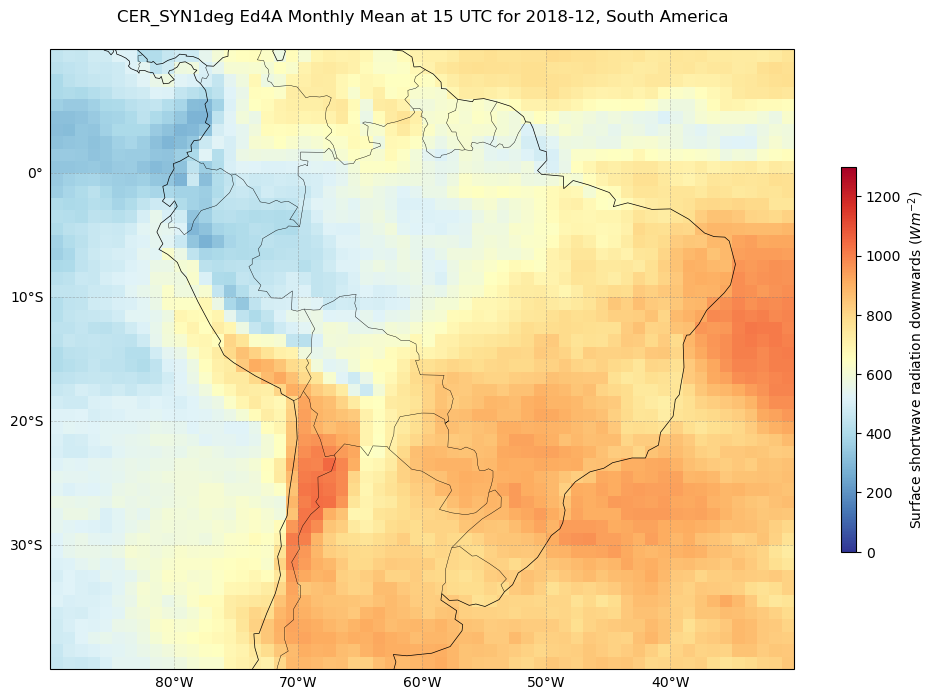

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_ISR_2018_12_15_SA.png


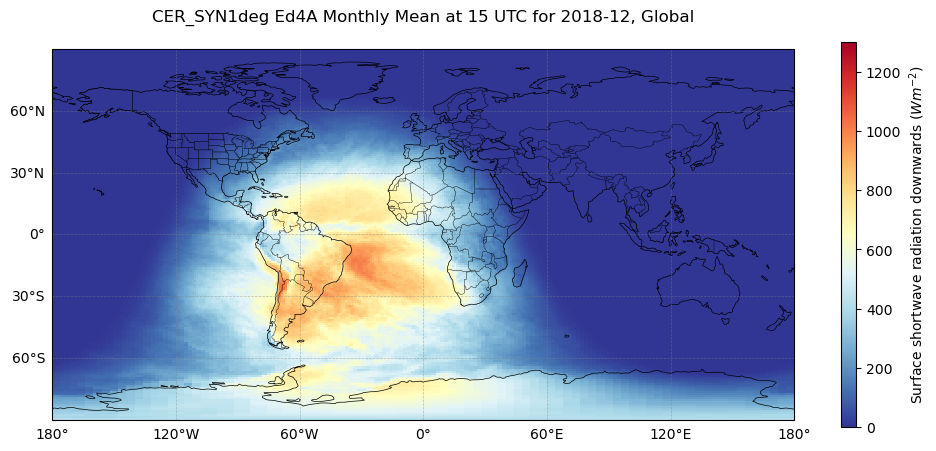

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_ISR_2018_12_15_Global.png


In [ ]:
if ceres_var_name in ceres_names:
    CER_data_sel_time = CER_data_xa.where(CER_data_xa['gmt_hr_index'] == UTC_hour_plot, drop=True)

    # Plot for each extent
    for myext in extents.keys():
        extent_label = extents[myext]["label"]
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

        # Plot the data (sorted by latitude to avoid ValueError)
        im = CER_data_sel_time[ceres_var_name].plot(
            ax=ax, 
            cmap='RdYlBu_r',
            vmin=var_dict[var]['vmin'],
            vmax=var_dict[var]['vmax'],
            cbar_kwargs={
                'shrink': 0.5,  # Make colorbar 70% of the plot height
                'aspect': 25,   # Control width (higher = thinner)
                'pad': 0.05,    # Space between plot and colorbar
                'label': f"{var_dict[var]['label']} (${var_dict[var]['unit']}$)"
            }
        )
        
        ax.set_extent(extents[myext]["extent"], crs=ccrs.PlateCarree())

        # Add geographic features
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.add_feature(cfeature.STATES, linewidth=0.2)

        # Add gridlines with labels
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}

        ax.set_title(f"CER_SYN1deg Ed4A Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}, {extent_label}", fontsize=12, pad=20)

        plt.tight_layout()
        out_png = f"{fig_path}/CER_SYN1deg_Ed4A_{var}_{year}_{month}_{UTC_hour_plot}_{myext}.png"
        plt.savefig(out_png, dpi=150, bbox_inches='tight')
        plt.show()

        print(f"Saved plot to: {out_png}")
        plt.close()
        
else:
    print(f"{ceres_var_name} not found in CERES dataset.")

#### Plotting CERES {var}monthly mean data 

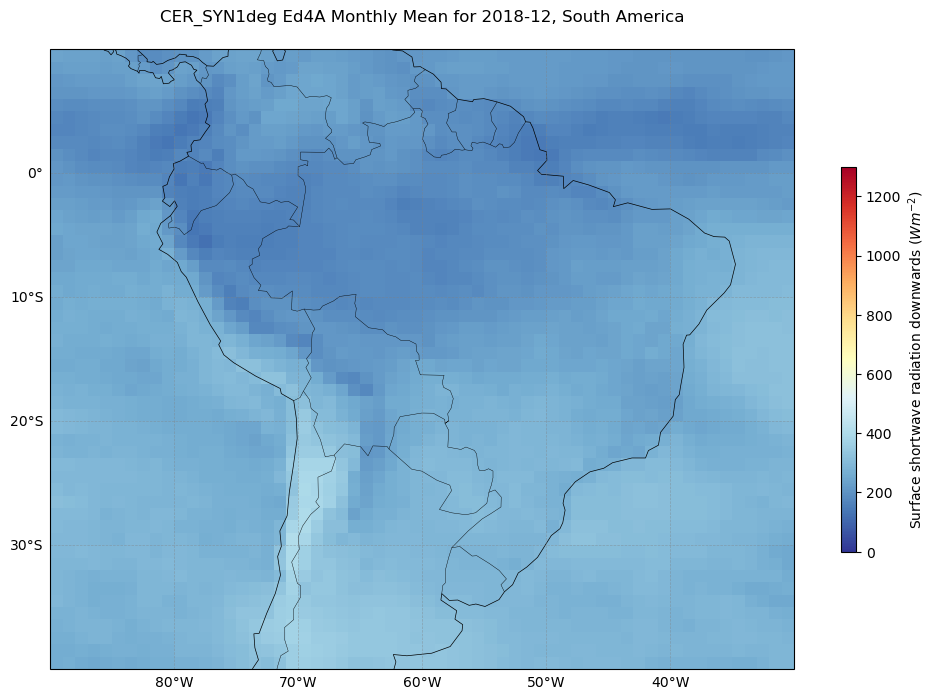

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_ISR_2018_12_mean_SA.png


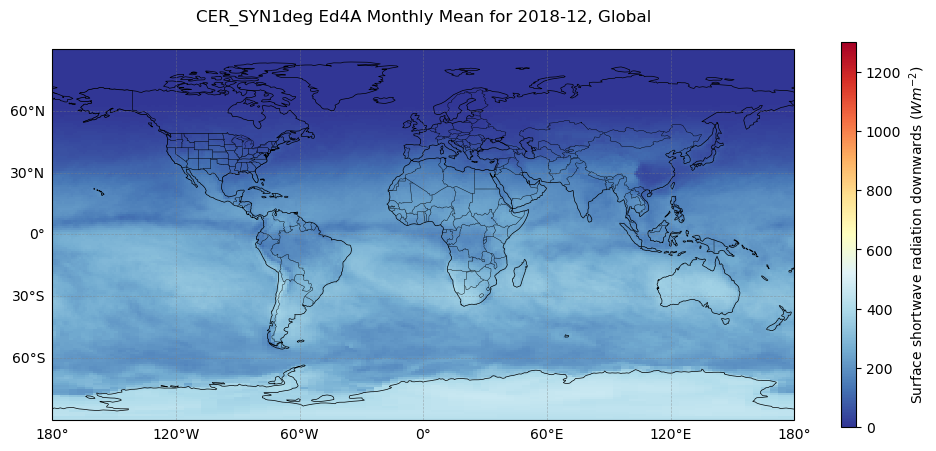

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_ISR_2018_12_mean_Global.png


In [ ]:
if ceres_var_name in ceres_names:
    CER_data_all_time = CER_data_xa[ceres_var_name].mean(dim='gmt_hr_index')

    # Plot for each extent
    for myext in extents.keys():
        extent_label = extents[myext]["label"]
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

        # Plot the data (sorted by latitude to avoid ValueError)
        im = CER_data_all_time.plot(
            ax=ax, 
            cmap='RdYlBu_r',
            vmin=var_dict[var]['vmin'],
            vmax=var_dict[var]['vmax'],
            cbar_kwargs={
                'shrink': 0.5,  # Make colorbar 70% of the plot height
                'aspect': 25,   # Control width (higher = thinner)
                'pad': 0.05,    # Space between plot and colorbar
                'label': f"{var_dict[var]['label']} (${var_dict[var]['unit']}$)"
            }
        )
        
        ax.set_extent(extents[myext]["extent"], crs=ccrs.PlateCarree())

        # Add geographic features
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.add_feature(cfeature.STATES, linewidth=0.2)

        # Add gridlines with labels
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}

        ax.set_title(f"CER_SYN1deg Ed4A Monthly Mean for {year}-{month}, {extent_label}", fontsize=12, pad=20)

        plt.tight_layout()
        out_png = f"{fig_path}/CER_SYN1deg_Ed4A_{var}_{year}_{month}_mean_{myext}.png"
        plt.savefig(out_png, dpi=150, bbox_inches='tight')
        plt.show()

        print(f"Saved plot to: {out_png}")
        plt.close()

else:
    print(f"{ceres_var_name} not found in CERES dataset.")

## Opening ERA5 {var} data

In [ ]:
era5_file_arg = base_dir+f"era5/single_levels/{year}/{month}/{var_dict[var]['era5_longname']}_MHour.nc"
era5_path = Path(era5_file_arg)
if not os.path.exists(era5_path):    
    print(f"File does not exist: {path!s}")
else:
    ds_era5 = xr.open_dataset(era5_path, engine="netcdf4")
    ds_era5 = apply_lon_lat_conventions(ds_era5)

    if var_dict[var]["convert_to_flux"]=="yes":
        ds_era5[era_var_name] = ds_era5[var_dict[var]["era5_name"]]/3600
        ds_era5[era_var_name].attrs = {'units': var_dict[var]["unit"]}
        ds_era5[era_var_name].attrs['description'] = f'Instantaneous flux calculated from accumulated {var_dict[var]["era5_name"].upper()}'
        print(ds_era5[era_var_name].attrs)
        print(ds_era5['valid_time'])
    else:
        print(ds_era5[var_dict[var]["era5_name"]].attrs)


{'units': 'W m^{-2}', 'description': 'Instantaneous flux calculated from accumulated SSRD'}
<xarray.DataArray 'valid_time' (valid_time: 24)> Size: 192B
array(['2018-12-01T01:00:00.000000000', '2018-12-01T02:00:00.000000000',
       '2018-12-01T03:00:00.000000000', '2018-12-01T04:00:00.000000000',
       '2018-12-01T05:00:00.000000000', '2018-12-01T06:00:00.000000000',
       '2018-12-01T07:00:00.000000000', '2018-12-01T08:00:00.000000000',
       '2018-12-01T09:00:00.000000000', '2018-12-01T10:00:00.000000000',
       '2018-12-01T11:00:00.000000000', '2018-12-01T12:00:00.000000000',
       '2018-12-01T13:00:00.000000000', '2018-12-01T14:00:00.000000000',
       '2018-12-01T15:00:00.000000000', '2018-12-01T16:00:00.000000000',
       '2018-12-01T17:00:00.000000000', '2018-12-01T18:00:00.000000000',
       '2018-12-01T19:00:00.000000000', '2018-12-01T20:00:00.000000000',
       '2018-12-01T21:00:00.000000000', '2018-12-01T22:00:00.000000000',
       '2018-12-01T23:00:00.000000000', '2018

## Plotting ERA5 {var} data at {UTC_hour_plot}

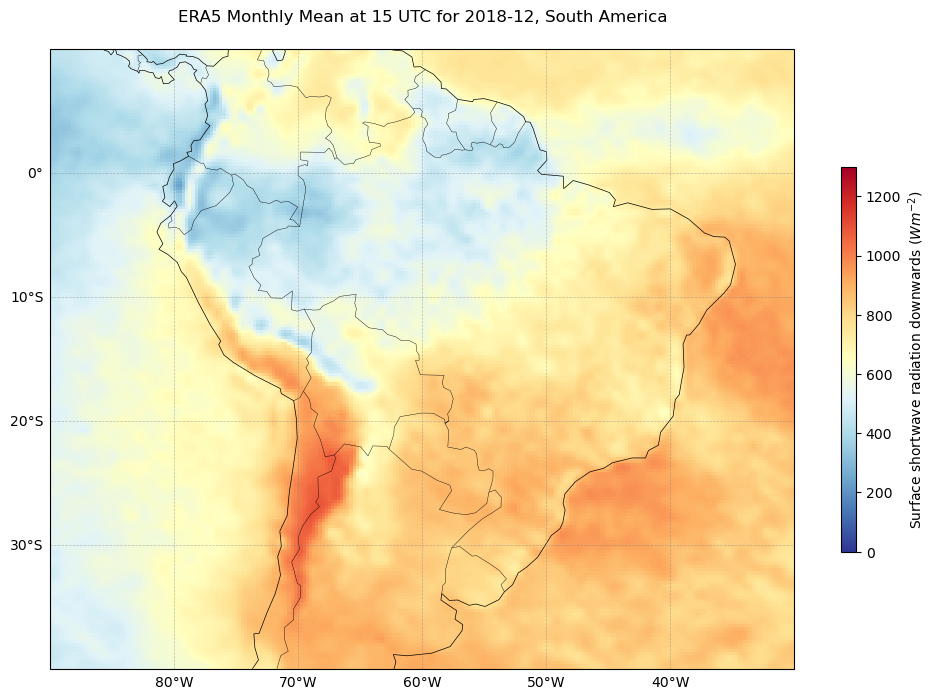

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ERA5_ISR_2018_12_15_SA.png


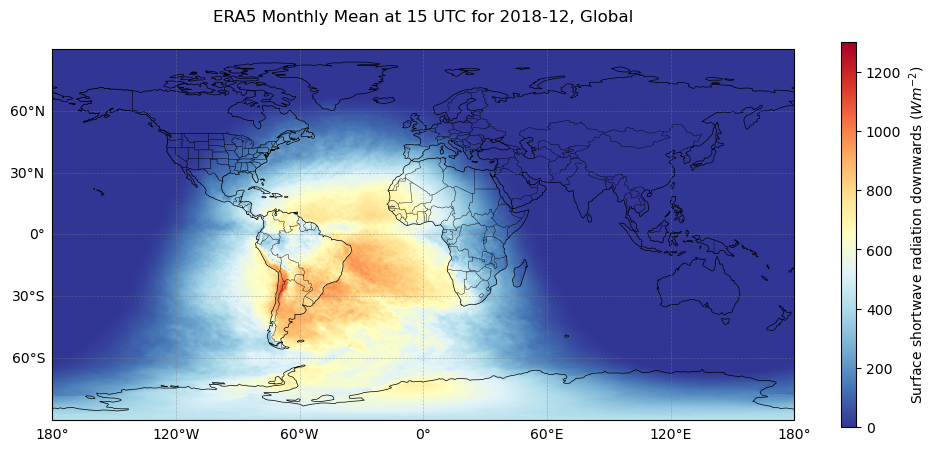

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ERA5_ISR_2018_12_15_Global.png


In [ ]:
if os.path.exists(era5_path):  
    ds_era5_sel_time = ds_era5.where(ds_era5['valid_time'].dt.hour == UTC_hour_plot, drop=True)

    # Plot for each extent
    for myext in extents.keys():
        extent_label = extents[myext]["label"]
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

        # Plot the data (sorted by latitude to avoid ValueError)
        im = ds_era5_sel_time[era_var_name].plot(
            ax=ax, 
            cmap='RdYlBu_r',
            vmin=var_dict[var]['vmin'],
            vmax=var_dict[var]['vmax'],
            cbar_kwargs={
                'shrink': 0.5,  # Make colorbar 70% of the plot height
                'aspect': 25,   # Control width (higher = thinner)
                'pad': 0.05,    # Space between plot and colorbar
                'label': f"{var_dict[var]['label']} (${var_dict[var]['unit']}$)"
            }
        )
        
        ax.set_extent(extents[myext]["extent"], crs=ccrs.PlateCarree())

        # Add geographic features
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.add_feature(cfeature.STATES, linewidth=0.2)

        # Add gridlines with labels
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}

        # Set title
        ax.set_title(f"ERA5 Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}, {extent_label}", fontsize=12, pad=20)

        plt.tight_layout()
        out_png = f"{fig_path}/ERA5_{var}_{year}_{month}_{UTC_hour_plot}_{myext}.png"
        plt.savefig(out_png, dpi=150, bbox_inches='tight')
        plt.show()

        print(f"Saved plot to: {out_png}")
        plt.close()

## Plotting ERA5 {var} monthly mean data

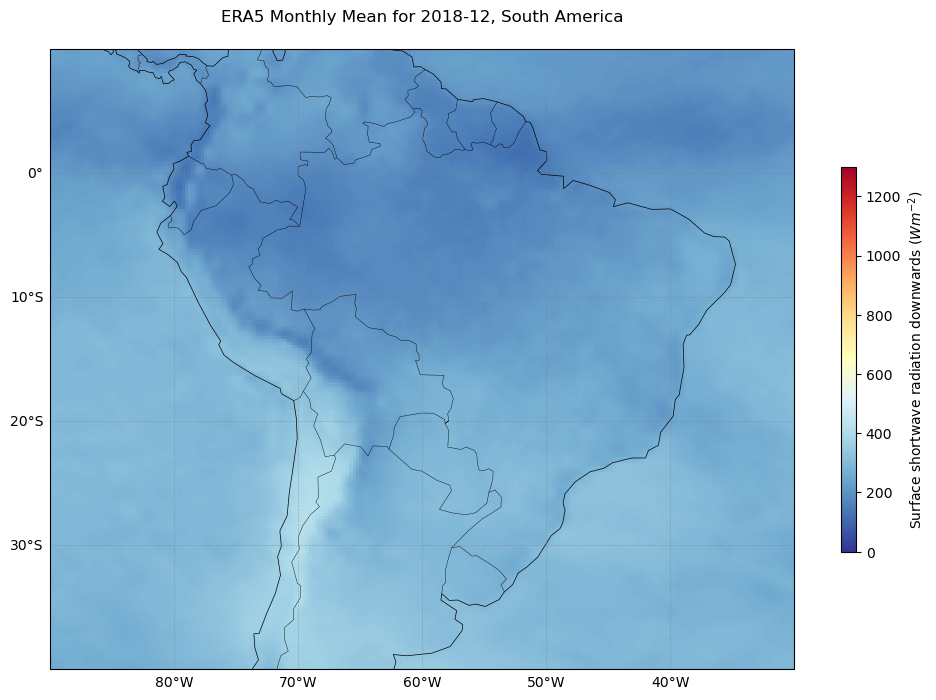

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ERA5_ISR_2018_12_mean_SA.png


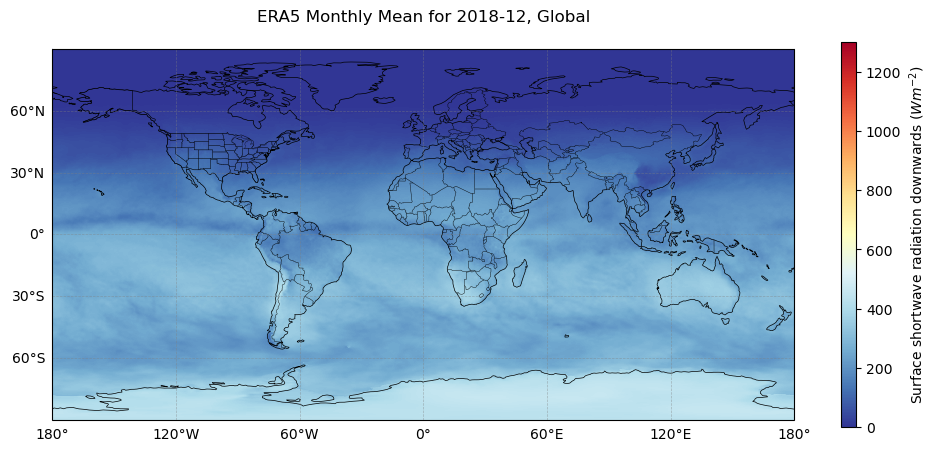

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ERA5_ISR_2018_12_mean_Global.png


In [ ]:
if os.path.exists(era5_path):  
    ds_era5_all_time = ds_era5.mean(dim='valid_time')

    # Plot for each extent
    for myext in extents.keys():
        extent_label = extents[myext]["label"]
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

        # Plot the data (sorted by latitude to avoid ValueError)
        im = ds_era5_all_time[era_var_name].plot(
            ax=ax, 
            cmap='RdYlBu_r',
            vmin=var_dict[var]['vmin'],
            vmax=var_dict[var]['vmax'],
            cbar_kwargs={
                'shrink': 0.5,  # Make colorbar 70% of the plot height
                'aspect': 25,   # Control width (higher = thinner)
                'pad': 0.05,    # Space between plot and colorbar
                'label': f"{var_dict[var]['label']} (${var_dict[var]['unit']}$)"
            }
        )
        
        ax.set_extent(extents[myext]["extent"], crs=ccrs.PlateCarree())

        # Add geographic features
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.add_feature(cfeature.STATES, linewidth=0.2)

        # Add gridlines with labels
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}

        # Set title
        ax.set_title(f"ERA5 Monthly Mean for {year}-{month}, {extent_label}", fontsize=12, pad=20)

        plt.tight_layout()
        out_png = f"{fig_path}/ERA5_{var}_{year}_{month}_mean_{myext}.png"
        plt.savefig(out_png, dpi=150, bbox_inches='tight')
        plt.show()

        print(f"Saved plot to: {out_png}")
        plt.close()

## Plotting MONAN - ERA5 {var} data at {UTC_hour_plot}

Plotting for experiment: CTRL


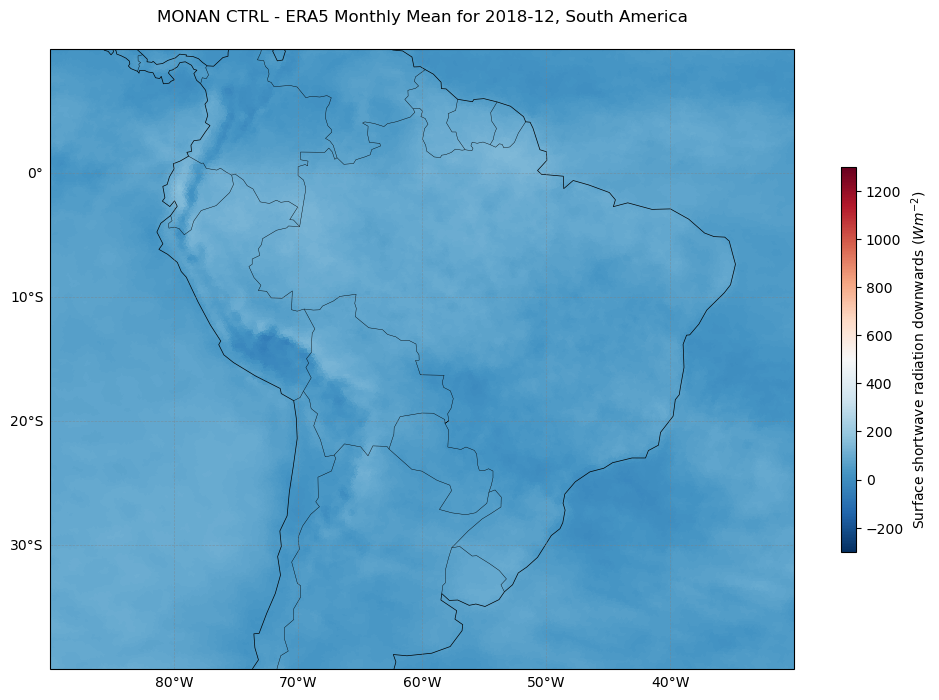

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_CTRL_ERA5_ISR_2018_12_mean_SA.png


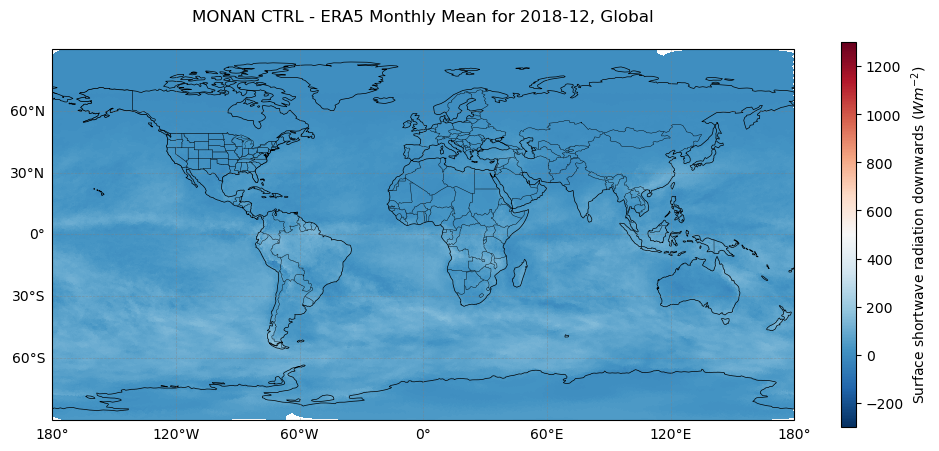

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_CTRL_ERA5_ISR_2018_12_mean_Global.png
Plotting for experiment: land_mult_24


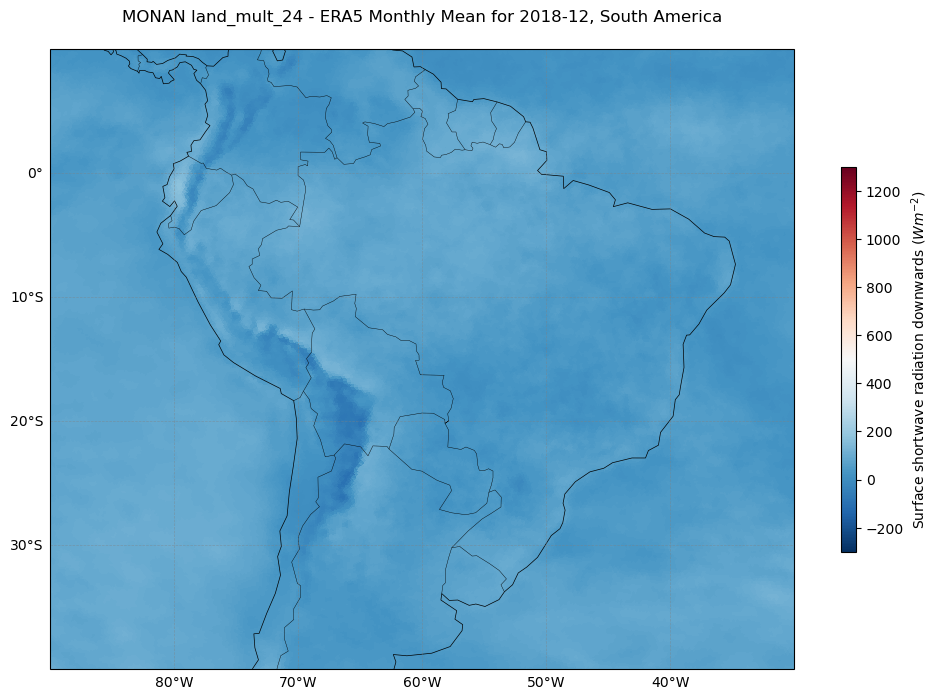

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_land_mult_24_ERA5_ISR_2018_12_mean_SA.png


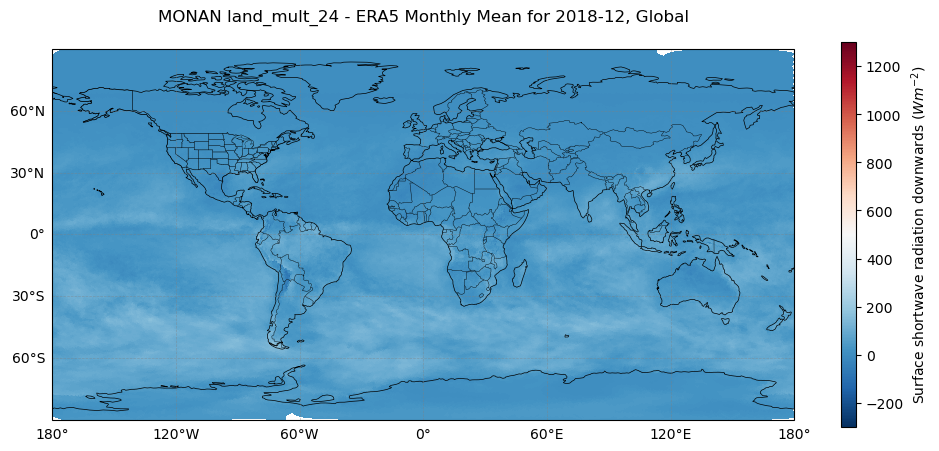

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_land_mult_24_ERA5_ISR_2018_12_mean_Global.png


In [ ]:
if os.path.exists(era5_path):  
    ds_era5_all_time = ds_era5.mean(dim='valid_time')

    for exp in ["CTRL", "land_mult_24"]:
        exp_name=exp
        print(f"Plotting for experiment: {exp_name}" )
        monan_dir=exps_data[exp]["dir"]

        monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{var_dict[var]["monan_name"]}_MHourly.nc'

        monan_path = Path(monan_file)
        if os.path.exists(monan_path):    
            # Get coordinates for interpolation
            monan_lons=exps_data[exp]["ds_monan"]['lon']
            monan_lats=exps_data[exp]["ds_monan"]['lat']
            
            # Interpolate ERA5 data to MONAN grid points
            era5_at_points = ds_era5_all_time.interp(
                latitude=monan_lats,
                longitude=monan_lons)
            monan_era5 = exps_data[exp]["ds_mean"] - era5_at_points[era_var_name]
            
            # Create triangulation
            tri = Triangulation(monan_lons, monan_lats)
            
            # Plot for each extent
            for myext in extents.keys():
                extent_label=extents[myext]["label"]
                
                # Create new figure for each experiment and extent
                fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
                
                # Plot
                tpc = ax.tripcolor(
                    tri, monan_era5, 
                    cmap="RdBu_r", 
                    shading="flat",
                    vmin=-300,
                    vmax=var_dict[var]['vmax']
                )
                ax.set_extent(extents[myext]["extent"], crs=ccrs.PlateCarree())
                plt.colorbar(tpc, label=f"{var_dict[var]['label']} (${var_dict[var]['unit']}$)", shrink=0.5, aspect=25, pad=0.05)

                # Add geographic features
                ax.coastlines(linewidth=0.5)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3)
                ax.add_feature(cfeature.STATES, linewidth=0.2)

                # Add gridlines with labels
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                gl.xlabel_style = {'size': 10}
                gl.ylabel_style = {'size': 10}

                # Set title
                ax.set_title(f"MONAN {exp_name} - ERA5 Monthly Mean for {year}-{month}, {extent_label}", fontsize=12, pad=20)

                plt.tight_layout()
                out_png = f"{fig_path}/MONAN_{exp_name}_ERA5_{var}_{year}_{month}_mean_{myext}.png"
                plt.savefig(out_png, dpi=150, bbox_inches='tight')
                plt.show()

                print(f"Saved plot to: {out_png}")
                plt.close()

## Plotting profile at {UTC_hour_plot} and {target_lon}

### Extract ERA5 Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
if os.path.exists(era5_path):  
    #Extract data from ERA5
    # Get the data variable at hour {UTC_hour_plot}
    era5_data_2d = ds_era5_sel_time

    # Find longitude index closest to target_lon
    era5_lon = era5_data_2d['longitude'].values
    era5_lon_idx = np.argmin(np.abs(era5_lon - target_lon))
    actual_lon = era5_lon[era5_lon_idx]

    # Extract slice at that longitude
    era5_slice = era5_data_2d.isel(longitude=era5_lon_idx)
    era5_lat = era5_slice['latitude'].values
    era5_values = era5_slice[era_var_name].values[0]

### Extract CERES Mhourly mean data  at {UTC_hour_plot} and {target_lon} 

In [ ]:
if ceres_var_name in ceres_names:
    # Get the data variable at hour {UTC_hour_plot}
    ceres_data_2d = CER_data_sel_time

    # Find longitude index closest to target_lon
    ceres_lon_idx = np.argmin(np.abs(lon_coords - target_lon))
    actual_ceres_lon = lon_coords[ceres_lon_idx]        

    # Extract slice at that longitude
    ceres_slice = ceres_data_2d.isel(lon=ceres_lon_idx)
    ceres_lat = ceres_slice['lat'].values
    ceres_values = ceres_slice[ceres_var_name].values[0]

### Extract MONAN Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
for exp_name in ["CTRL", "land_mult_24"]:
    print(f"Extracting slice for experiment: {exp_name}" )
    monan_dir=exps_data[exp_name]["dir"]
    monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{var_dict[var]["monan_name"]}_MHourly.nc'
    monan_path = Path(monan_file)

    if os.path.exists(monan_path):    
        monan_lons=exps_data[exp_name]["ds_monan"]['lon'].values
        monan_lats =exps_data[exp_name]["ds_monan"]['lat'].values
        monan_data_2d = exps_data[exp_name]["ds_sel_time"].values

        # Select longitude = {target_lon} (nearest index)
        tol=0.05
        mask = np.abs(monan_lons - target_lon) < tol
        monan_lat_slice = monan_lats[mask]
        monan_slice = monan_data_2d[mask]

        # Order by latitude
        order = np.argsort(monan_lat_slice)
        exps_data[exp_name]["monan_lat_slice_sorted"] = monan_lat_slice[order]
        exps_data[exp_name]["monan_slice_sorted_selhour"] = monan_slice[order]
        print("slice extracted")
    else:
        print(f"File does not exist: {monan_path!s}")


Extracting slice for experiment: CTRL
slice extracted
Extracting slice for experiment: land_mult_24
slice extracted


### Create the plot

Plotting latitude slice for experiment: CTRL
Plotting latitude slice for experiment: land_mult_24
Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ISR_201812_15UTC_lon-60.png


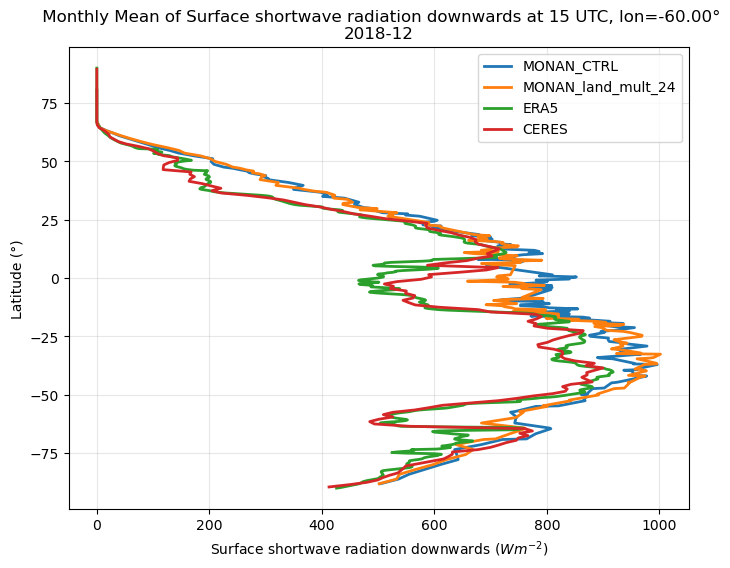

In [ ]:
plt.figure(figsize=(8, 6))
for exp_name in ["CTRL", "land_mult_24"]:
    print(f"Plotting latitude slice for experiment: {exp_name}" )
    monan_dir=exps_data[exp_name]["dir"]
    monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{var_dict[var]["monan_name"]}_MHourly.nc'
    monan_path = Path(monan_file)

    if os.path.exists(monan_path):
        plt.plot(exps_data[exp_name]["monan_slice_sorted_selhour"], exps_data[exp_name]["monan_lat_slice_sorted"], label=f"MONAN_{exp_name}", linewidth=2)
if os.path.exists(era5_path):
    plt.plot(era5_values, era5_lat, label=f"ERA5", linewidth=2)
if ceres_var_name in ceres_names:
    plt.plot(ceres_values, ceres_lat, label=f"CERES", linewidth=2)
plt.xlabel(f"{var_dict[var]['label']} (${var_dict[var]['unit']})$")
plt.ylabel('Latitude (°)')
plt.title(f" Monthly Mean of {var_dict[var]['label']} at {UTC_hour_plot} UTC, lon={actual_lon:.2f}°\n{year}-{month}")
plt.grid(True, alpha=0.3)
plt.legend()

# Save the plot
out_png = f"{fig_path}/{var}_{year}{month}_{UTC_hour_plot}UTC_lon{int(actual_lon)}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {out_png}")
plt.show()
plt.close()

## Plotting profile for monthly mean and {target_lon}

### Extract ERA5 Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
if os.path.exists(era5_path):  
    #Extract data from ERA5
    # Get the data variable at hour {UTC_hour_plot}
    era5_data_2d = ds_era5_all_time[era_var_name]

    # Find longitude index closest to target_lon
    era5_lon = era5_data_2d['longitude'].values
    era5_lon_idx = np.argmin(np.abs(era5_lon - target_lon))
    actual_lon = era5_lon[era5_lon_idx]

    # Extract slice at that longitude
    era5_slice = era5_data_2d.isel(longitude=era5_lon_idx)
    era5_lat = era5_slice['latitude'].values
    era5_values = era5_slice.values

### Extract CERES Mhourly mean data  at {UTC_hour_plot} and {target_lon} 

In [ ]:
if ceres_var_name in ceres_names:
    # Get the data variable at hour {UTC_hour_plot}
    ceres_data_2d = CER_data_all_time

    # Find longitude index closest to target_lon
    ceres_lon_idx = np.argmin(np.abs(lon_coords - target_lon))
    actual_ceres_lon = lon_coords[ceres_lon_idx]        

    # Extract slice at that longitude
    ceres_slice = ceres_data_2d[:,ceres_lon_idx]
    ceres_values = ceres_slice

### Extract MONAN Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
for exp_name in ["CTRL", "land_mult_24"]:
    print(f"Extracting slice for experiment: {exp_name}" )
    monan_dir=exps_data[exp_name]["dir"]
    monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{var_dict[var]["monan_name"]}_MHourly.nc'
    monan_path = Path(monan_file)

    if os.path.exists(monan_path):    
        monan_lons=exps_data[exp_name]["ds_monan"]['lon'].values
        monan_lats =exps_data[exp_name]["ds_monan"]['lat'].values
        monan_data_2d = exps_data[exp_name]["ds_mean"].values

        # Select longitude = {target_lon} (nearest index)
        tol=0.05
        mask = np.abs(monan_lons - target_lon) < tol
        monan_lat_slice = monan_lats[mask]
        monan_slice = monan_data_2d[mask]

        # Order by latitude
        order = np.argsort(monan_lat_slice)
        exps_data[exp_name]["monan_lat_slice_sorted"] = monan_lat_slice[order]
        exps_data[exp_name]["monan_slice_sorted_monmean"] = monan_slice[order]
        print("slice extracted")
    else:
        print(f"File does not exist: {monan_path!s}")


Extracting slice for experiment: CTRL
slice extracted
Extracting slice for experiment: land_mult_24
slice extracted


### Create the plot

Plotting latitude slice for experiment: CTRL
Plotting latitude slice for experiment: land_mult_24
Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ISR_201812_24_accum_lon-60_land_mult_24.png


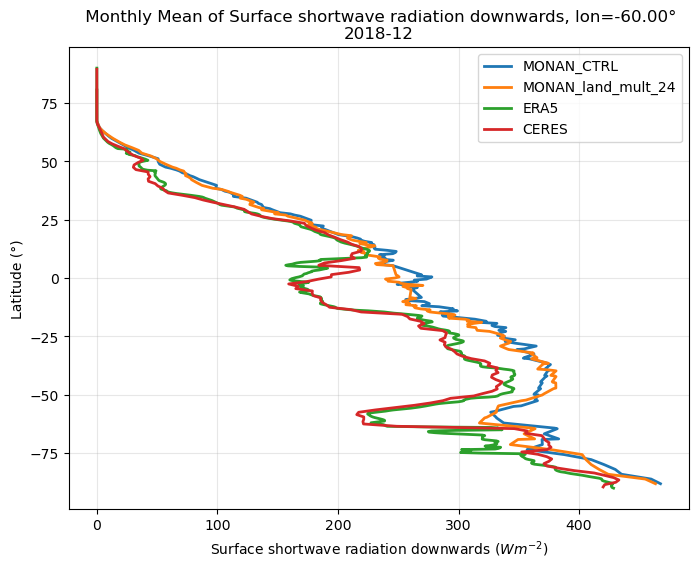

In [ ]:
plt.figure(figsize=(8, 6))
for exp_name in ["CTRL", "land_mult_24"]:
    print(f"Plotting latitude slice for experiment: {exp_name}" )
    monan_dir=exps_data[exp_name]["dir"]
    monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{var_dict[var]["monan_name"]}_MHourly.nc'
    monan_path = Path(monan_file)

    if os.path.exists(monan_path):
        plt.plot(exps_data[exp_name]["monan_slice_sorted_monmean"], exps_data[exp_name]["monan_lat_slice_sorted"], label=f"MONAN_{exp_name}", linewidth=2)
if os.path.exists(era5_path):
    plt.plot(era5_values, era5_lat, label=f"ERA5", linewidth=2)
if ceres_var_name in ceres_names:
    plt.plot(ceres_values, ceres_lat, label=f"CERES", linewidth=2)
plt.xlabel(f"{var_dict[var]['label']} (${var_dict[var]['unit']})$")
plt.ylabel('Latitude (°)')
plt.title(f" Monthly Mean of {var_dict[var]['label']}, lon={actual_lon:.2f}°\n{year}-{month}")
plt.grid(True, alpha=0.3)
plt.legend()

# Save the plot
out_png = f"{fig_path}/{var}_{year}{month}_24_accum_lon{int(actual_lon)}_{exp_name}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {out_png}")
plt.show()
plt.close()

### Closing MONAN and ERA5 files

In [ ]:
ds_monan.close()
ds_era5.close()

NameError: name 'ds_monan' is not defined

### Closing CERES file

In [ ]:
try:
    sd.end()
except Exception:
    pass